<a href="https://colab.research.google.com/github/kinaya18/Deep-Learning/blob/main/Week-7/Bidirectional_RNN_DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Muhammad Aizar Yazid / 1103223097

## **Import Library**

In [3]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Load JSON

In [4]:
data = []
with open('DeteksiSarkasme.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [5]:
sentences = [item['headline'] for item in data]
labels = np.array([item['is_sarcastic'] for item in data])

## Data Preparation

In [6]:
vocab_size = 10000
embedding_dim = 64
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [9]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

## Modeling

In [10]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6768 - loss: 0.5735 - val_accuracy: 0.8547 - val_loss: 0.3342 - learning_rate: 0.0010
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9112 - loss: 0.2348 - val_accuracy: 0.8624 - val_loss: 0.3178 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9508 - loss: 0.1362 - val_accuracy: 0.8633 - val_loss: 0.3553 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9733 - loss: 0.0822 - val_accuracy: 0.8551 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9900 - loss: 0.0417 - val_accuracy: 0.8502 - val_loss: 0.5958 - learning_rate: 2.0000e-04


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,248,133 (8.58 MB)

 Trainable params: 749,377 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,498,756 (5.72 MB)

## Evaluation

In [14]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)

print("\n===== Evaluation Metrics =====")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


===== Evaluation Metrics =====
Accuracy : 0.8624
Precision: 0.8525
Recall   : 0.8303
F1 Score : 0.8413
AUC      : 0.9377


## Visualisasi

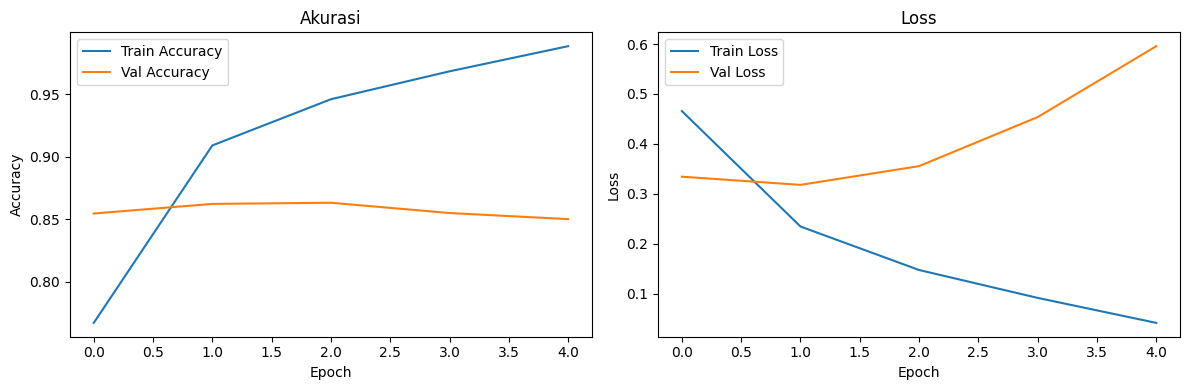

In [16]:
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()